In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
import seaborn as sns
import scipy.io as sio

import epych

In [3]:
%matplotlib inline

In [4]:
data = sio.loadmat('/mnt/data/LabAssignment/data.mat', simplify_cells=True, struct_as_record=False)

/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
electrode_info = pd.read_csv('/mnt/data/LabAssignment/electrodeInfo.csv')

In [6]:
trial_info = pd.read_csv('/mnt/data/LabAssignment/trialInfo.csv').set_index("trial")

In [7]:
trial_info.columns

Index(['task', 'cueType', 'isSwitch', 'blockNum', 'sample', 'dist1', 'dist2',
       'targetLoc', 'dist1Loc', 'dist2Loc', 'responseLoc', 'outcome',
       'correct', 'reactionTime', 'trialStart', 'fixptOn', 'fixationTime',
       'sampleOn', 'sampleOff', 'testOn', 'responseDone', 'session',
       'trialRefTimes', 'badTimingTrials', 'badTrials'],
      dtype='object')

In [8]:
event_units = collections.defaultdict(lambda: None, trialStart=pq.second, fixptOn=pq.second, fixationTime=pq.second,
                                      sampleOn=pq.second, sampleOff=pq.second, testOn=pq.second, responseDone=pq.second,
                                      start=pq.second, end=pq.second)

In [9]:
dt = data['lfpSchema']['smpInterval'][0]

In [10]:
times = data['lfpSchema']['index'][0]

In [11]:
lfp = epych.signals.lfp.LocalFieldPotential(electrode_info, data['lfp'].swapaxes(0, 1), dt, times)

In [12]:
series = epych.recording.Sampling(pd.DataFrame(columns=["trial", "type", "start", "end"]), trial_info, event_units, lfp=lfp)

In [13]:
trials = series.select_trials(lambda row: row == 0, 'badTrials')

In [14]:
cued_lfp = trials.time_lock(trials.trials['sampleOn'].mean(), before=0.5, after=0.5).signals['lfp']

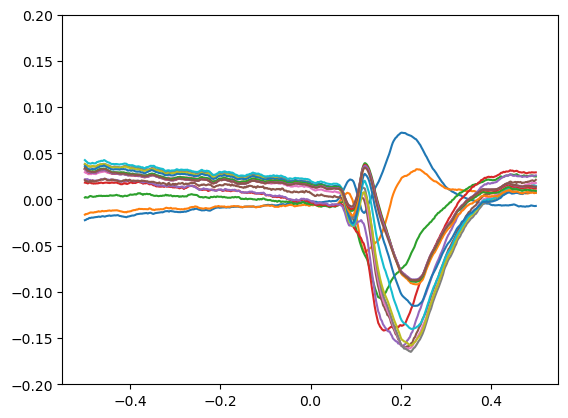

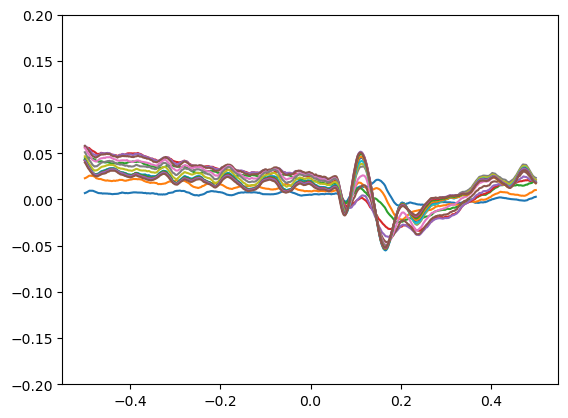

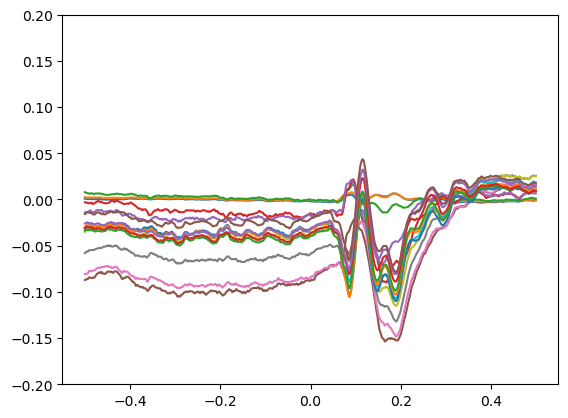

In [15]:
for area in ['VLPFC1', '7A', 'V4 Foveal']:
    lfp = cued_lfp.select_channels('area', area)
    erp = lfp.erp()

    ax = plt.gca()
    erp.line_plot()
    ax.set_ylim(bottom=-0.2, top=0.2)
    plt.show()

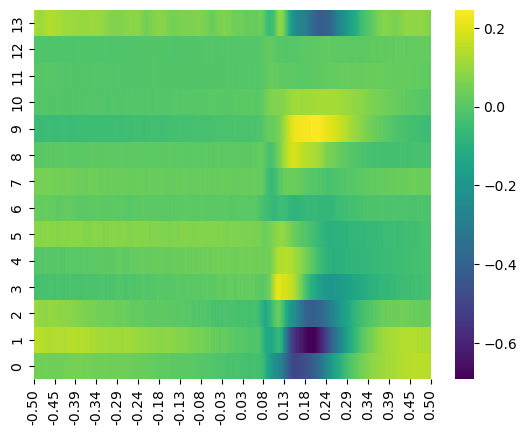

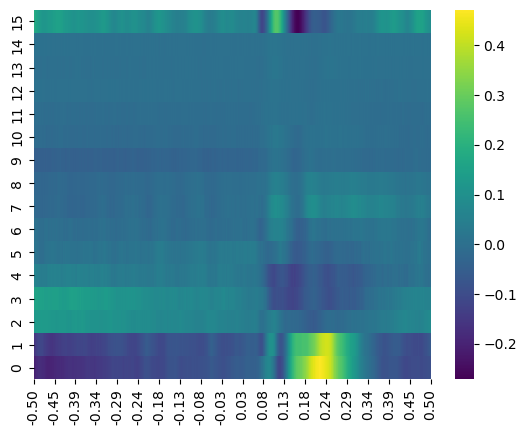

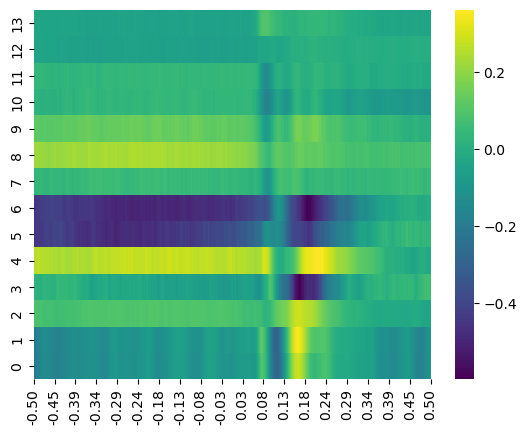

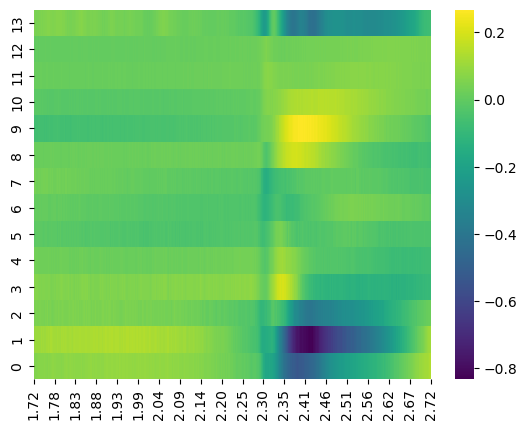

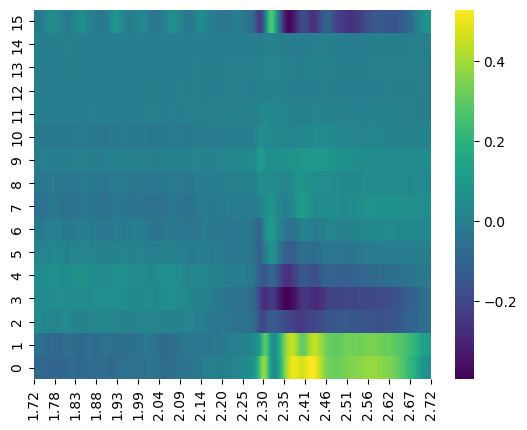

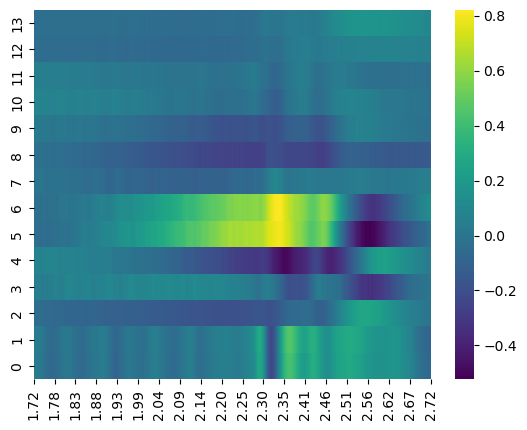

In [16]:
for event in ['sampleOn', 'testOn']:
    event_time = trials.trials[event].mean()
    event_csds = trials.time_lock(event_time, before=0.5, after=0.5).signals['lfp'].csd(0.4, 0.2)
    for area in ['VLPFC1', '7A', 'V4 Foveal']:
        csd = event_csds.select_channels('area', area).erp()
        csd.plot()
        ax = plt.gca()
        # ax.set_ylim(bottom=-0.2, top=0.2)
        plt.show()

## 1 second pre-sample-onset to 1 second post-sample-onset (samples 501-2500)

In [17]:
cued_lfp = trials.time_lock(trials.trials['sampleOn'].mean(), before=1., after=1.).signals['lfp']

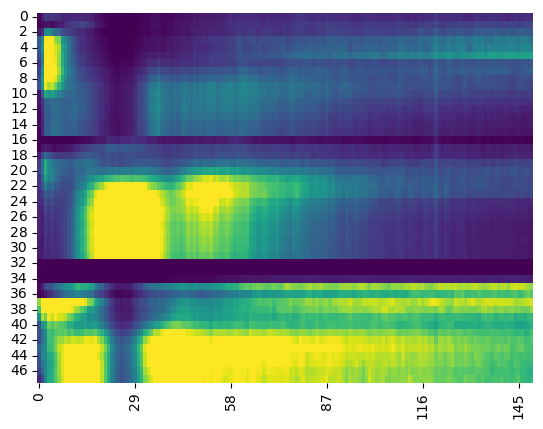

In [18]:
spectrum = cued_lfp.power_spectrum(dBs=False, relative=True, taper=np.hanning).trial_mean()
spectrum.heatmap(fbottom=0., ftop=150.)

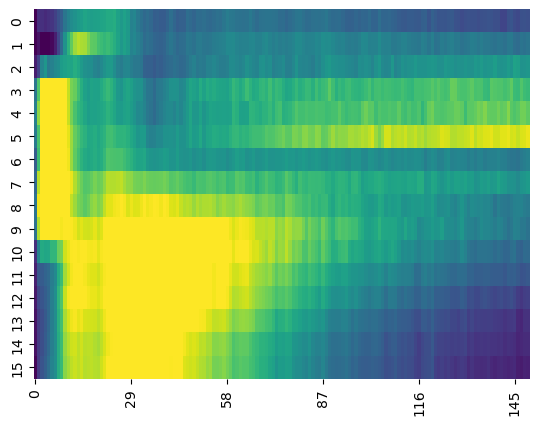

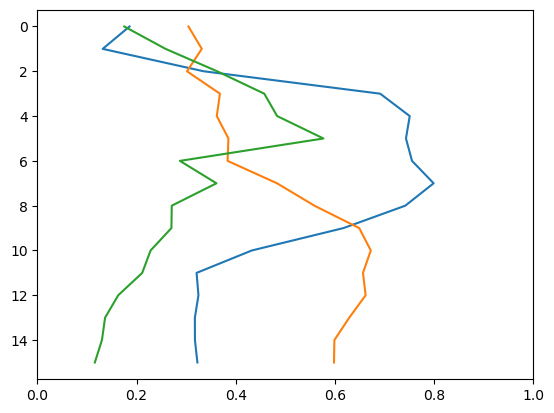

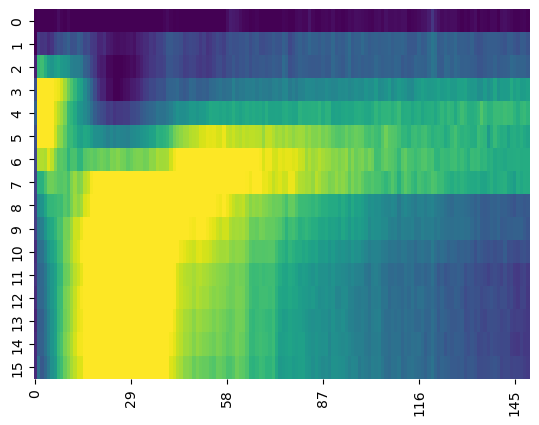

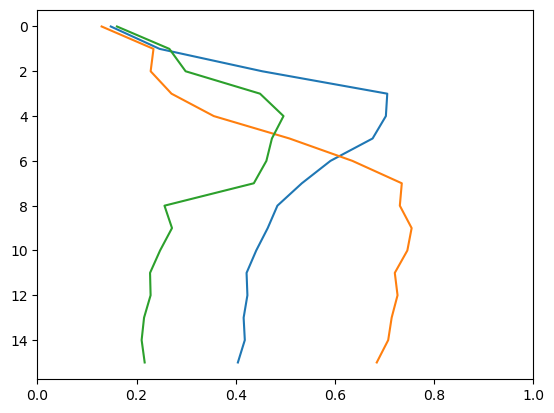

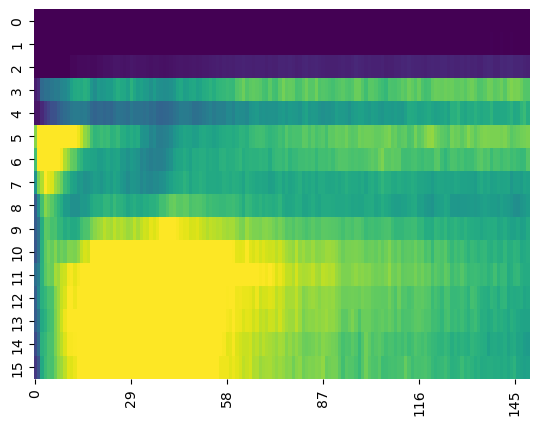

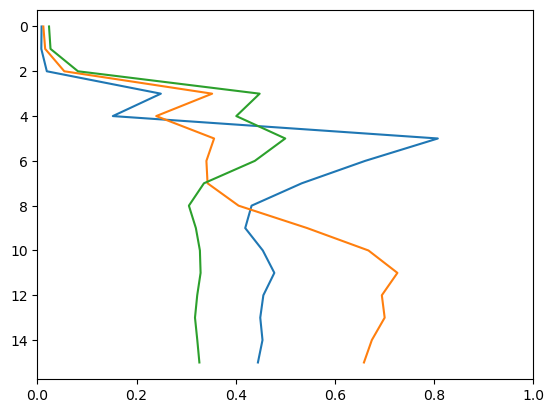

In [19]:
for area in ['VLPFC1', '7A', 'V4 Foveal']:
    lfp = cued_lfp.select_channels('area', area)
    spectrum = lfp.power_spectrum(dBs=False, relative=True, taper=np.hanning).trial_mean()
    spectrum.heatmap(fbottom=0., ftop=150.)
    plt.show()

    band_powers = [spectrum.band_power(*epych.spectrum.THETA_BAND),
                   spectrum.band_power(*epych.spectrum.ALPHA_BETA_BAND),
                   spectrum.band_power(*epych.spectrum.GAMMA_BAND)]

    for band in band_powers:
        spectrum.plot_channels(band, xlims=(0., 1.))
    plt.show()

In [20]:
sampleOns = trials.time_lock(trials.trials['sampleOn'].mean(), before=1., after=1.)

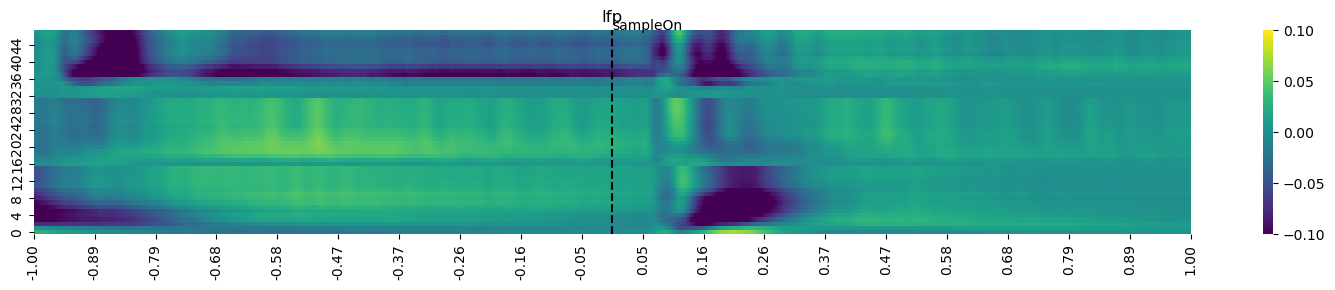

In [21]:
erp = sampleOns.erp()
erp.plot(vmin=-1e-1, vmax=1e-1, sampleOn=erp.trials['sampleOn'].item())